In [1]:
from models.MTrans import MTrans
from easydict import EasyDict
import yaml
import torch
from PIL import Image
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from utils.calibrator import KittiCalibrator_detect
from utils.point_ops import check_points_in_box, build_image_location_map_single

In [3]:
def load_checkpoint(file_path, model, optim=None, scheduler=None):
    ckpt = torch.load(file_path)
    model_ckpt = ckpt['model_state_dict']
    model.load_state_dict(model_ckpt)
    if optim is not None:
        optim.load_state_dict(ckpt['optimizer_state_dict'])
    if scheduler is not None:
        scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    epoch = ckpt['epoch']
    return epoch

In [4]:
cfg_file = 'configs/MTrans_kitti.yaml'
cfg = EasyDict(yaml.safe_load(open(cfg_file)))
cfg['out_img_size'] = 112
cfg['out_cloud_size'] = 512

train_cfg, dataset_cfg, loader_cfg = cfg.TRAIN_CONFIG, cfg.DATASET_CONFIG, cfg.DATALOADER_CONFIG

In [5]:
model = MTrans(cfg.MODEL_CONFIG)
# start_epoch = load_checkpoint('best_model.pt', model) + 1

In [6]:
ckpt = torch.load('original_best_model.pt')
model_ckpt = ckpt['model_state_dict']
model.load_state_dict(model_ckpt)

<All keys matched successfully>

In [28]:

from datasets.kitti_detection import KittiDetectionDataset
from datasets.kitti_loader import build_kitti_loader
dataset = KittiDetectionDataset
loader_builder = build_kitti_loader

In [29]:
training_set_for_gen_label = dataset(cfg.data_root, cfg.DATASET_CONFIG.TRAIN_SET, gen_pseudolabel=cfg.gen_label, nusc=False)

In [30]:
training_loader_for_gen_label = loader_builder(training_set_for_gen_label, cfg, cfg.DATALOADER_CONFIG.TRAIN_LOADER, 1, 1)

In [31]:
# for data in training_loader_for_gen_label:
#     print(data)
#     break
    
data = next(iter(training_loader_for_gen_label))
data['locations']

tensor([[24.0199, -0.4306, -0.7638],
        [20.0195,  5.1293, -0.9469],
        [19.4189,  5.0685, -0.8588],
        [39.7181, -3.5102, -0.4673],
        [24.1788, -5.5226, -0.5260]])

In [38]:
data.keys()
# plt.imshow(data['images'][0].permute(1,2,0))
# plt.scatter(data['sub_cloud2d'][:,0], data['sub_cloud2d'][:,1])
# data['sub_cloud2d'].shape
# data['dimensions']

dict_keys(['use_3d_label', 'images', 'overlap_masks', 'sub_clouds', 'sub_clouds2d', 'ori_clouds2d', 'real_point_mask', 'foreground_label', 'classes', 'boxes_2d', 'locations', 'dimensions', 'yaws', 'frames', 'truncated', 'occluded', 'class_names', 'weights', 'calibs', 'sub_cloud2d'])

In [32]:
out = model(data)

In [33]:
out['location'] + out['subcloud_center'] + out['second_offset']
# out['subcloud_center']

tensor([[24.3899,  0.3096, -0.5037],
        [19.2277,  6.8055, -1.1033],
        [18.4579,  4.9004, -0.9836],
        [40.0657, -2.9869, -0.5853],
        [24.2056, -4.4212, -0.5329]], grad_fn=<AddBackward0>)

# Build_dataset

In [7]:
def build_overlap_matrix(object_labels):
    num_labels = len(object_labels)
    overlap_matrix = [[] for _ in range(num_labels)]
    for i in range(num_labels):
        for j in range(i+1, num_labels):
            b1 = object_labels[i]['box_2d']     # left, top, right, bottom
            b2 = object_labels[j]['box_2d']
            overlap_vertical = max(b1[1], b2[1]) < min(b1[3], b2[3])
            overlap_horizontal = max(b1[0], b2[0]) < min(b1[2], b2[2]) 
            if overlap_vertical and overlap_horizontal:
                overlap_matrix[i].append(j)
                overlap_matrix[j].append(i)
    return overlap_matrix

In [362]:
all_objects = []

seq = 0
frame = 150
image_file = '/home/user/Downloads/kitti_object_tracking/training/image_02/{:04d}/{:06d}.png'.format(seq, frame)
img = Image.open(image_file)
img = T.ToTensor()(img)
H, W = img.shape[1:3]


velo_file = '/home/user/Downloads/kitti_object_tracking/training/velodyne/{:04d}/{:06d}.bin'.format(seq, frame)
label_file = '/home/user/Downloads/kitti_object_tracking/training/label_02/{:04d}.txt'.format(seq)
calib_file = '/home/user/Downloads/kitti_object_tracking/training/calib/{:04d}.txt'.format(seq)

with open(velo_file, 'rb') as f:
    point_cloud = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
    
    
calib = KittiCalibrator_detect(calib_file)


p2d_float, depth = calib.velo_to_cam(point_cloud[:, :3])
x, y = p2d_float[:, 0], p2d_float[:, 1]
idx = np.logical_and.reduce([depth>=0, x>=0, x<W, y>=0, y<H])
point_cloud = point_cloud[idx]
p2d_float = p2d_float[idx]




with open(label_file) as f:
    labels = [l.strip().split(' ') for l in f.readlines()]
object_labels = []
btcdet_mask = []
for label in labels:
    if int(label[0])<frame:
        continue
    elif int(label[0])>frame:
        break
    if label[2] == 'DontCare':
        continue
    cls = label[2]
    truncated = float(label[3])
    if truncated > 0.95:    # remove too much truncated
        btcdet_mask.append(False)
        continue
    btcdet_mask.append(True)

    occluded = int(label[4])
    box_2d = np.array(label[6:10], dtype=np.float32)
    dim = np.array(label[10:13], dtype=np.float32)
    loc = np.array(label[13:16], dtype=np.float32)
    yaw = float(label[16])

    # change label coordinate system: camera sys -> lidar sys
    location = calib.rect_to_velo(loc[np.newaxis, ...])
    x, y, z = location[0]
    h, w, l = dim
    z += h/2
    yaw = -yaw - np.pi/2

    object_labels.append({
        'class': cls,
        'truncated': truncated,
        'occluded': occluded,
        'box_2d': box_2d,
        'dimensions': np.array([l, w, h]),
        'location': np.array([x, y, z]),
        'yaw': yaw,
    })

    if len(label)==16:
        score = float(label[15])
        object_labels[-1]['score'] = score
        
print(object_labels)
overlap_matrix = build_overlap_matrix(object_labels)

for i, obj in enumerate(object_labels):
    obj['frame'] = frame

    # query sub cloud within the 2D box
    left, top, right, bottom = obj['box_2d']
    idx = np.logical_and.reduce([p2d_float[:, 0]>left, p2d_float[:, 1]>top, p2d_float[:, 0]<right, p2d_float[:, 1]<bottom])
    sub_cloud = point_cloud[idx]
    sub_cloud2d = p2d_float[idx]
    obj['sub_cloud'] = sub_cloud
    obj['sub_cloud2d'] = sub_cloud2d

    # Generate foreground label     # NOTE This is only used for the loss calculation
    foreground_label = check_points_in_box(sub_cloud[:, :3], location=obj['location'], dimension=obj['dimensions'], yaw=obj['yaw']) 
    obj['foreground_label'] = foreground_label

    overlap_boxes = [object_labels[j]['box_2d'] for j in overlap_matrix[i]]
    obj['overlap_boxes'] = overlap_boxes

    # Modified-Added-Changed by Helbert PAAT
    obj['weight'] = float(1)

    all_objects.append(obj)


[{'class': 'Van', 'truncated': 0.0, 'occluded': 1, 'box_2d': array([551.7274 , 164.29156, 584.3375 , 199.97104], dtype=float32), 'dimensions': array([4.433886, 1.823255, 2.      ], dtype=float32), 'location': array([43.32514572,  2.58291626, -0.14350951]), 'yaw': 0.07462867320510336}, {'class': 'Cyclist', 'truncated': 0.0, 'occluded': 0, 'box_2d': array([565.10077, 166.26878, 616.2351 , 267.13647], dtype=float32), 'dimensions': array([1.785241, 0.824591, 1.739063], dtype=float32), 'location': array([13.70121288,  0.44965789, -0.6963259 ]), 'yaw': 0.0881466732051035}, {'class': 'Van', 'truncated': 0.0, 'occluded': 1, 'box_2d': array([ 84.1538 , 176.42714, 343.22702, 325.37625], dtype=float32), 'dimensions': array([4.314977, 1.711916, 1.773438], dtype=float32), 'location': array([11.16186619,  5.6472311 , -0.86163998]), 'yaw': -3.0896493267948966}, {'class': 'Car', 'truncated': 0.0, 'occluded': 0, 'box_2d': array([709.6568 , 167.22911, 933.4796 , 321.42093], dtype=float32), 'dimensions':

# load_object_full_data

In [363]:
# [x['score'] for x in all_objects]
# all_objects[0].keys()
len(all_objects)
# all_objects

9

In [364]:
img_coords = build_image_location_map_single(cfg.out_img_size, cfg.out_img_size, 'cpu')

obj = all_objects[1]

cloud_size = cfg.out_cloud_size

full_img = Image.open(image_file)
full_img = T.ToTensor()(full_img)


overlap_mask = torch.ones_like(full_img[0:1, :, :])
for olb in obj['overlap_boxes']:
    print(olb)
    l, t, r, b = olb
    l, t, r, b = int(np.floor(l)), int(np.floor(t)), int(np.ceil(r)), int(np.ceil(b))
    overlap_mask[:, t:b, l:r] = 0
    
full_img = torch.cat([full_img, overlap_mask], dim=0) # C+1 x H x W

l, t, r, b = obj['box_2d']

l, t, r, b = int(np.floor(l)), int(np.floor(t)), int(np.ceil(r)), int(np.ceil(b))
img = full_img[:,t:b, l:r].unsqueeze(0)  # (1, 4, box_h, box_w)     # Crop the image to get the image corresponding to the 2D box only


# crop original image by the obj's 2D box
box_size = max(b-t, r-l)
out_shape = cfg.out_img_size
img = torch.nn.functional.interpolate(img, scale_factor=out_shape/box_size, mode='bilinear', align_corners=True, recompute_scale_factor=False) # (1, 4, new_box_h, new_box_w)
h, w = img.shape[-2:]
num_padding = (int(np.floor((out_shape-w)/2)), int(np.ceil((out_shape-w)/2)), int(np.floor((out_shape-h)/2)), int(np.ceil((out_shape-h)/2)))
img = torch.nn.functional.pad(img, num_padding)     # 1 x 4 x W x W # Zero-padding to make it square
crop_sub_cloud2d = (obj['sub_cloud2d'] - np.array([l, t])) * (out_shape/box_size) + np.array([num_padding[0], num_padding[2]]) # TODO Intuition? # Nl x 2


np.logical_and.reduce([crop_sub_cloud2d[:, 0]>=0, crop_sub_cloud2d[:,0]<=112.01, crop_sub_cloud2d[:, 1]>=0, crop_sub_cloud2d[:,1]<=112.01]).all()  


img, overlap_mask = img[:, 0:3, :, :], img[:, 3:4, :, :] # 1 x 3 x W x W    # 1 x 1 x W x W # TODO What is the intuition of the overlap_mask?


# sampling the point cloud to fixed size
out_sub_cloud = np.ones((cloud_size, 4))* (-9999)       # cloud_size x 4 # -9999 for paddings
out_sub_cloud2d = np.ones((cloud_size, 2)) * (-9999)    # cloud_size x 4 # -9999 for paddings
out_ori_cloud2d = np.ones((cloud_size, 2)) * (-9999)    # cloud_size x 2 
out_real_point_mask = np.zeros((cloud_size))    # cloud_size  # 0 for padding, 1 for real points, 2 for masked, 3 for jittered
out_foreground_label = np.ones((cloud_size))*2  # cloud_size  # 0 for background, 1 for foreground, 2 for unknown


sub_cloud = obj['sub_cloud']     # Nl x 4
sub_cloud2d = obj['sub_cloud2d'] # Nl x 2
foreground_label = obj['foreground_label'] # Nl
out_cloud_size = cfg.out_cloud_size# 512


if sub_cloud.shape[0] > out_cloud_size:
    sample_idx = np.random.choice(np.arange(sub_cloud.shape[0]), out_cloud_size, replace=False)     # out_cloud_size=512       # random sampling
    out_sub_cloud[...] = sub_cloud[sample_idx]              # out_cloud_size x 4 # TODO Why is this the size? 
    out_sub_cloud2d[...] = crop_sub_cloud2d[sample_idx]     # out_cloud_size x 2 # TODO Understand crop_sub_cloud2d
    out_ori_cloud2d[...] = sub_cloud2d[sample_idx]          # out_cloud_size x 2
    out_real_point_mask[...] = 1                            # out_cloud_size # TODO All 1 for now?
    out_foreground_label[...] = foreground_label[sample_idx]    # out_cloud_size
    pc_size = out_cloud_size
elif sub_cloud.shape[0] <= out_cloud_size:
    pc_size = sub_cloud.shape[0]
    out_sub_cloud[:pc_size] = sub_cloud             # Nl x 4
    out_sub_cloud2d[:pc_size] = crop_sub_cloud2d    # Nl x 2
    out_ori_cloud2d[:pc_size] = sub_cloud2d         # Nl x 2
    out_real_point_mask[:pc_size] = 1               # Nl
    out_foreground_label[:pc_size] = foreground_label # Nl
    
    

# sample 2D points, leave blank for 3D coords
p = ((img[0]!=0).all(dim=0) * 1).numpy().astype(np.float64)   # W x W # only sample pixels from not-padding-area
p = p / p.sum() # W x W
resample = (p>0).sum() < (out_cloud_size - pc_size) # TODO Why do the comparison?
sample_idx = np.random.choice(np.arange(out_shape * out_shape), out_cloud_size - pc_size, replace=resample,
                              p=p.reshape(-1)) # (out_cloud_size - pc_size)
sampled_c2d = img_coords.view(-1, 2)[sample_idx, :].numpy() # (out_cloud_size - pc_size) x 2
out_sub_cloud2d[pc_size:, :] = sampled_c2d      # TODO How about the out_sub_cloud?
out_ori_cloud2d[pc_size:, :] = (sampled_c2d - np.array([num_padding[0], num_padding[2]])) / (out_shape/box_size) + np.array([l, t]) 


assert np.logical_and.reduce([out_ori_cloud2d[:pc_size, 0]>=l, out_ori_cloud2d[:pc_size,0]<=r,
                         out_ori_cloud2d[:pc_size, 1]>=t, out_ori_cloud2d[:pc_size,1]<=b]).all()


# random mask/jitter points
num_real_points = (out_real_point_mask==1).sum() 
mask_ratio = np.random.rand() * (cfg.DATASET_CONFIG.VAL_SET.mask_ratio[1] - cfg.DATASET_CONFIG.VAL_SET.mask_ratio[0]) + cfg.DATASET_CONFIG.VAL_SET.mask_ratio[0]  # How many will we mask? # randomly choose from (r_min, r_max) # self.cfg.mask_ratio = [0.25, 0.95]
num_mask = min(int(mask_ratio * num_real_points), max(0, num_real_points - 5)) # leave at least 5 points # How often is the case that num_real_points<=5
idx = np.random.choice(np.arange(num_real_points), num_mask, replace=False)           # num_mask 
mask_idx = idx                                                                        # num_mask 
out_real_point_mask[mask_idx] = 2           # out_cloud_size   # 2 for masked   # TODO Intuition? 

print(img.shape)


obj['frame_img'] = img                              # 1 x 3 x W x W
obj['sub_cloud'] = out_sub_cloud                    # out_cloud_size x 4
obj['sub_cloud2d'] = out_sub_cloud2d                # out_cloud_size x 2
obj['ori_cloud2d'] = out_ori_cloud2d                # out_cloud_size x 2
obj['real_point_mask'] = out_real_point_mask        # out_cloud_size
obj['foreground_label'] = out_foreground_label      # out_cloud_size
obj['overlap_mask'] = overlap_mask                  # 1 x 1 x W x W

[551.7274  164.29156 584.3375  199.97104]
torch.Size([1, 3, 112, 112])


In [365]:
input_data = obj

images = torch.cat([input_data['frame_img']], dim=0)
overlap_masks = torch.cat([input_data['overlap_mask']], dim=0)
sub_clouds = torch.from_numpy(np.stack([input_data['sub_cloud']])).float()
print(overlap_masks.shape)
real_point_mask = torch.from_numpy(np.stack([input_data['real_point_mask']]))


batched_data = EasyDict({
    'images':images,
    'overlap_masks': overlap_masks,
    'sub_clouds': sub_clouds,
    'sub_clouds2d': torch.from_numpy(np.stack([input_data['sub_cloud2d']])).float(),
    'ori_clouds2d': torch.tensor(1),
    'real_point_mask': real_point_mask,
    'foreground_label': torch.tensor(1),
    'locations': torch.from_numpy(np.stack([np.array([0,0,0])])).float(),
    'dimensions': torch.from_numpy(np.stack([np.array([4,1.6,1.5])])).float(),
    'yaws': torch.from_numpy(np.stack([0])).unsqueeze(-1).float()
})

torch.Size([1, 1, 112, 112])


In [366]:
out = model(batched_data)

In [367]:
out['conf']

tensor([[0.1912]], grad_fn=<SigmoidBackward0>)

In [368]:
loc = out['location'] + out['subcloud_center'] + out['second_offset']
loc = loc.detach().cpu()
print(loc)
# out['subcloud_center']

tensor([[14.6623,  0.4190, -0.6566]])


In [369]:
# print(out['location'][0], out['dimension'][0])
gamma = torch.cat([out['location'][0], out['dimension'][0], out['yaw'][0]], dim=0)
params = {
    'x': list(),
    'y': list(),
    'z': list(),
    'l': list(),
    'w': list(),
    'h': list(),
    'yaw': list(),
}

for i, p in enumerate(params.keys()):
    params[p].append(gamma[i].item())
    params[p].append(out['box_uncertainty'][0][0][i].item()) # lambda
    params[p].append(out['box_uncertainty'][1][0][i].item()) # alpha
    params[p].append(out['box_uncertainty'][2][0][i].item()) # beta


In [370]:
params['x'], params['y']

([0.9602842926979065,
  0.6119056940078735,
  1.1122276782989502,
  0.6373077630996704],
 [-0.014602556824684143,
  0.49062156677246094,
  1.2786993980407715,
  0.04708848521113396])

In [371]:
import copy
new_params = copy.deepcopy(params)

new_params['x'][0] += (out['subcloud_center'][0][0] + out['second_offset'][0][0]).item()
new_params['y'][0] += (out['subcloud_center'][0][1] + out['second_offset'][0][1]).item()
new_params['z'][0] += (out['subcloud_center'][0][2] + out['second_offset'][0][2]).item()
new_params

{'x': [14.662283957004547,
  0.6119056940078735,
  1.1122276782989502,
  0.6373077630996704],
 'y': [0.41901375353336334,
  0.49062156677246094,
  1.2786993980407715,
  0.04708848521113396],
 'z': [-0.65658800303936,
  0.2431790977716446,
  1.9639172554016113,
  0.004756600130349398],
 'l': [4.428981781005859,
  0.08976806700229645,
  2.4354171752929688,
  0.040034133940935135],
 'w': [1.6040014028549194,
  0.1363479197025299,
  2.242199182510376,
  0.001871683169156313],
 'h': [1.9525229930877686,
  0.14420218765735626,
  2.192410469055176,
  0.0028779683634638786],
 'yaw': [0.007780874148011208,
  0.490663081407547,
  1.4531011581420898,
  0.11119858175516129]}

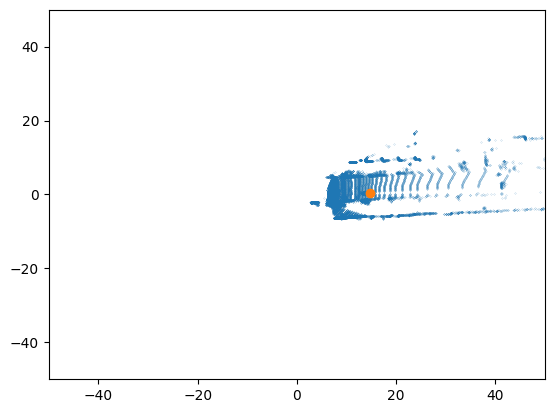

In [372]:
plt.scatter(point_cloud[:,0], point_cloud[:,1], s=0.01)
plt.scatter(loc[0][0], loc[0][1])
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

# make as the ambiguity set

In [373]:
import pickle
target_cdf = 0.99
a_memory = dict()
with open(f'../a_memory_sets/a_memory_{target_cdf}.pickle', 'rb') as f:
    a_memory = pickle.load(f)

In [374]:
def create_surrogate_ambiguity_set(params):
    '''
    params: [mu_0, lambda_, alpha, beta]
    '''
    mu_0, lambda_, alpha, beta = params
    try:
        mu_low, mu_high, sigma2_low, sigma2_high = a_memory[float(f'{alpha:.02f}')]
    except:
        mu_low, mu_high, sigma2_low, sigma2_high = a_memory[float(f'{1.01}')]

        
    mu_low = mu_low / np.sqrt(lambda_/beta) + mu_0
    mu_high = mu_high / np.sqrt(lambda_/beta) + mu_0
    sigma2_low = sigma2_low * beta
    sigma2_high = sigma2_high * beta
    return mu_low, mu_high, sigma2_low, sigma2_high

In [375]:
x_ambiguity_set = create_surrogate_ambiguity_set(new_params['x'])
y_ambiguity_set = create_surrogate_ambiguity_set(new_params['y'])

In [376]:
def get_DRO_solution(ambiguity_set, ego_position):
    '''
    ambiguity set: parameter ranges [mu_low, mu_high, sigma2_low, sigma2_high]
    ego position: ego vehicle's position [x] (calculate for each axis)
    
    일단은 2가지 경우로 하고,
    나중에 3가지 경우로 중간에 애매한 위치일 경우 sigma2를 바꾸는걸로 고치자
    '''
    mu_low, mu_high, sigma2_low, sigma2_high = ambiguity_set
    
    if mu_low <= ego_position <= mu_high:
        # 안에 포함됨
        mu = ego_position
        sigma2 = sigma2_low
    elif ego_position < mu_low:
        # 왼쪽에 떨어져 있음
        mu = mu_low
        sigma2 = sigma2_high
    
    else: # ego_position > mu_high
        # 오른쪽에 가까이 있음
        mu = mu_high
        sigma2 = sigma2_high
        
    return mu, sigma2

In [377]:
def Unscented_Transform(dist, ego_position):
    '''
    input
    - dist: perception distribution
    - ego_position: ego vehicle's position (for loss calculation)

    output
    - loss_dist: loss distance distribution
    '''

    mu, Sigma = dist
    mu = torch.tensor(mu, dtype=torch.float)[None,:]
    Sigma = torch.tensor(Sigma, dtype=torch.float)[None, :,:]
    # cholesky matrix
    chol_matrices = torch.linalg.cholesky(Sigma)

    # UT params
    alpha = 1e-3
    beta = 2.0
    kappa = 0.0
    n = mu.shape[1]
    lambda_ = torch.tensor(alpha**2 * (n + kappa) - n, dtype=torch.float)

    # Compute weights
    Wm = torch.full((2 * n + 1,), 1 / (2 * (n + lambda_)))  # Mean weights
    Wm[0] = lambda_ / (n + lambda_)

    Wc = Wm.clone()  # Covariance weights
    Wc[0] += 1 - alpha**2 + beta

    # Generate sigma points for the entire batch
    scaling = torch.sqrt(n + lambda_)
    sigma_points = []

    # Central sigma points
    sigma_points.append(mu)

    # Positive and negative directions
    for i in range(n):
        sigma_points.append(mu + scaling * chol_matrices[:, :, i])
        sigma_points.append(mu - scaling * chol_matrices[:, :, i])

    # Stack sigma points into a batch tensor
    sigma_points = torch.stack(sigma_points, dim=1)  # Shape: (batch, 2n+1, n)

    def nonlinear_transform(obs_position, ego_position):
        print(obs_position.shape, ego_position)
        target = torch.tensor(ego_position)  # Point (3, 4)
        distance = 10-torch.sqrt(torch.sum((obs_position - target)**2, dim=-1))  # Euclidean distance
        return distance  # Add last dimension for compatibility


    transformed_sigma_points = nonlinear_transform(sigma_points, ego_position)

    # Compute transformed means (batch)
    transformed_means = torch.sum(Wm[None, :] * transformed_sigma_points, dim=1)

    # Compute transformed covariances (batch)
    diff = transformed_sigma_points - transformed_means[:, None]
    transformed_variances = torch.sum(Wc[None, :] * diff**2, dim=1)#torch.einsum('bij,bi,bik->bjk', diff, Wc[None], diff)

    transformed_std = torch.sqrt(transformed_variances)

    return transformed_means, transformed_std

In [378]:
def calculate_CVaR(dist, ego_position):
    '''
    input:
    - dist: worst case multivariate normal distribution ([mu_x, Mu_y], [[sigma2_x, 0], [0, sigma2_y]])
    - ego_position: ego vehicle's position for loss computation
    
    '''
    loss_mu, loss_sigma = Unscented_Transform(dist, ego_position)
    loss_dist = norm(loss_mu, scale=loss_sigma)
    
    epsilon = 0.95
    target_cdf = 0.50
    kappa = norm.pdf(norm.ppf(epsilon))/(1-epsilon)
    loss_CVaR = loss_mu + kappa * loss_sigma
    
    return loss_CVaR

[(10.814399802516027, -0.7160506505467021), (10.814399802516027, 1.5540781576134288), (18.510168111493066, 1.5540781576134288), (18.510168111493066, -0.7160506505467021)]


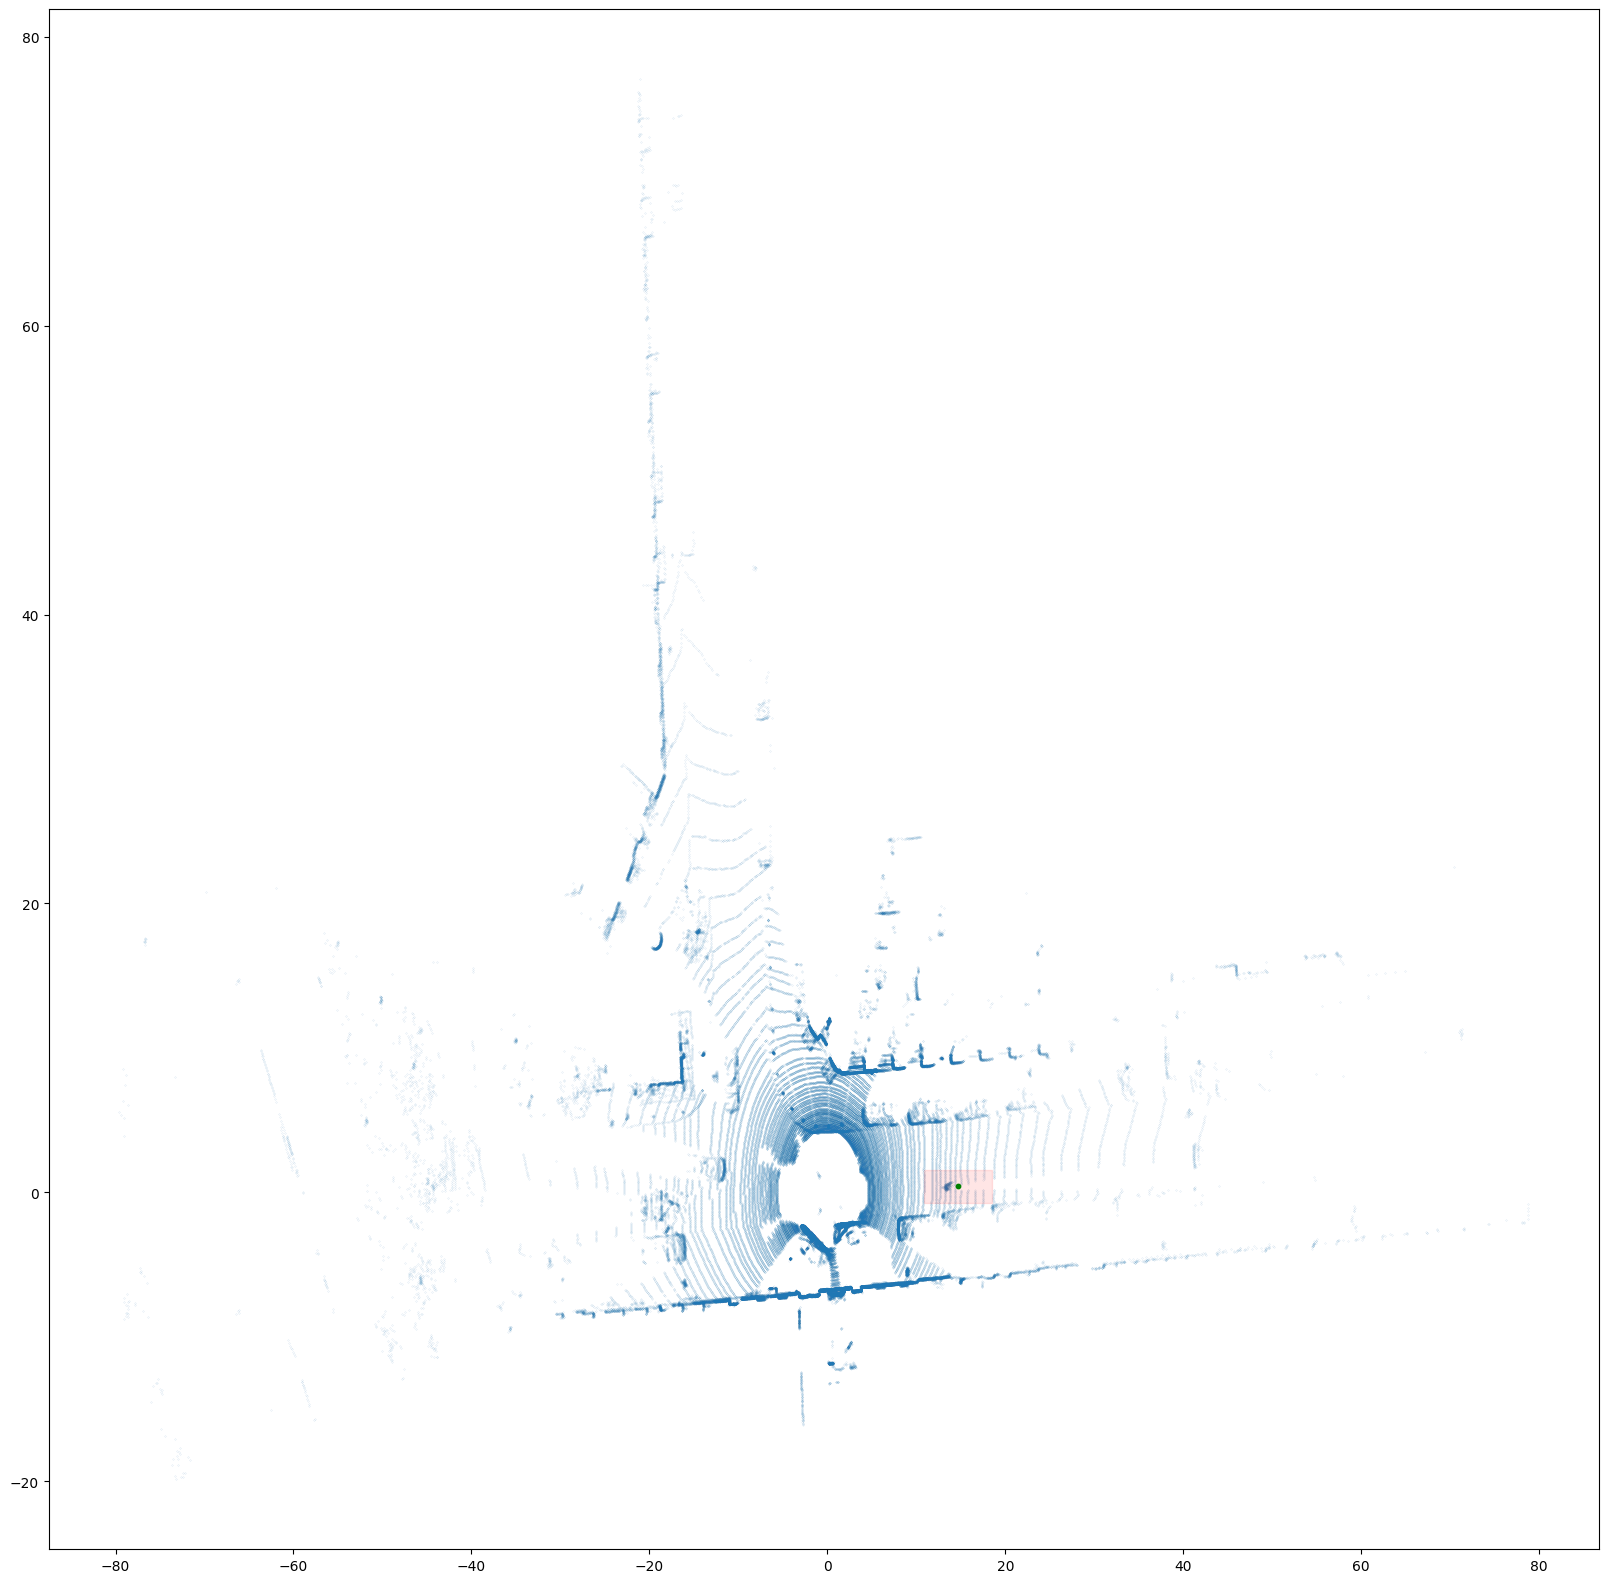

In [379]:
from matplotlib.patches import Polygon
from ipywidgets import interact, FloatSlider
from tqdm import tqdm

x_mu_low, x_mu_high, _, _ = x_ambiguity_set
y_mu_low, y_mu_high, _, _ = y_ambiguity_set
# print("ambiguity set: ",x_mu_low, x_mu_high, y_mu_low, y_mu_high)

vertices = [(x_mu_low, y_mu_low), (x_mu_low, y_mu_high), (x_mu_high, y_mu_high), (x_mu_high, y_mu_low)]
print(vertices)
rectangle = Polygon(vertices, closed=True, color='red', alpha=0.1)

fig, ax = plt.subplots(figsize=(20,20))
with open(velo_file, 'rb') as f:
    point_cloud = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
ax.scatter(point_cloud[:,0], point_cloud[:,1], s=0.01, alpha=0.5)
ax.add_patch(rectangle)
ax.scatter(loc[0][0], loc[0][1], color='g', s=10)

plt.show()

# ----------------Deprecated!------------------

# image, lidar, box 읽기

In [6]:
def read_calib_file(calib_path):
    """
    KITTI calibration txt 파일을 읽어서 
    필요한 행렬들을 딕셔너리로 반환
    """
    data = {}
    with open(calib_path, 'r') as f:
        for line in f.readlines():
            if len(line.strip()) == 0:
                continue
            key, value = line.split(' ', 1)
            value = value.strip()
            # value를 공백 기준으로 나눈 후 float 변환
            data[key] = np.array(list(map(float, value.split())))
    return data


def get_matrices(calib_path):
    data = read_calib_file(calib_path)

    # P2는 3x4
    P2 = data['P2:'].reshape(3, 4)

    # R0_rect는 3x3
    R0_rect = data['R_rect'].reshape(3, 3)

    # Tr_velo_to_cam은 3x4 -> 4x4로 확장
    Tr_velo_to_cam = data['Tr_velo_cam'].reshape(3, 4)
    Tr_velo_to_cam_4x4 = np.vstack((Tr_velo_to_cam, [0, 0, 0, 1]))  # 마지막 행 추가

    return P2, R0_rect, Tr_velo_to_cam_4x4


In [76]:
KittiCalibrator_detect(calib_file)

In [81]:
seq = 0
calib_file = '/home/user/Downloads/kitti_object_tracking/training/calib/{:04d}.txt'.format(seq)
image_file = '/home/user/Downloads/kitti_object_tracking/training/image_02/{:04d}/000000.png'.format(seq)
velo_file = '/home/user/Downloads/kitti_object_tracking/training/velodyne/{:04d}/000000.bin'.format(seq)
label_file = '/home/user/Downloads/kitti_object_tracking/training/label_02/{:04d}.txt'.format(seq)

# read image
img = Image.open(image_file)
img_tensor = T.ToTensor()(img)
# read point cloud
with open(velo_file, 'rb') as f:
    pcd = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

# read calibration info
# P2, R0_rect, Tr_velo_to_cam = get_matrices(calib_file)
calib = KittiCalibrator_detect(calib_file)


# read bbox


# f = open(label_file, 'r')
# obj_label = dict()
# for obj in f.readlines():
#     frame, track_id, cat, trunc, occ, alpha, l, t, r, b, height, width, length, x, y, z, rot = obj.split(' ')
#     if frame not in obj_label.keys():
#         obj_label[frame] = list()
#     if cat == 'DontCare':
#         continue
#     obj_label[frame].append([l, t, r, b, x, y, z])




In [61]:
# print(obj_label['0'])
bounding_boxes = [[float(y) for y in x[:4]] for x in obj_label['0']]
print(bounding_boxes)

[[296.744956, 161.752147, 455.226042, 292.372804], [737.619499, 161.531951, 931.112229, 374.0], [1106.137292, 166.576807, 1204.470628, 323.876144]]


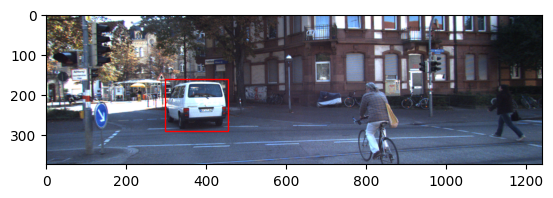

In [8]:
import matplotlib.patches as patches

l, t, r, b, s1, s2, s3 = [float(x) for x in obj_label['0'][0]]
x, y, z = s3, -s1, s2

w = r-l
h = b-t
fig, ax = plt.subplots()
ax.imshow(img)
rect = patches.Rectangle((l, t), w, h, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [9]:

def project_velo_to_image(points_velo, P2, R0_rect, Tr_velo_to_cam):
    """
    Velodyne 좌표계의 점들을 이미지 픽셀 (u,v)로 매핑
    points_velo: Nx3 혹은 Nx4 (동차좌표)
    """
    # points_velo가 Nx3이면 Nx4로 확장
    if points_velo.shape[1] == 3:
        ones = np.ones((points_velo.shape[0], 1))
        points_velo_hom = np.hstack((points_velo, ones))  # [x, y, z, 1]
    else:
        points_velo_hom = points_velo

    # 1) velodyne -> camera0
    points_cam0_hom = Tr_velo_to_cam @ points_velo_hom.T  # 결과는 4xN
    points_cam0_hom = points_cam0_hom[:3, :]  # (x, y, z) 만 추출 (3xN)

    # 2) R0_rect 적용 (3x3 * 3xN = 3xN)
    points_cam0_rect = R0_rect @ points_cam0_hom  # 3xN

    # 3) Camera 2 projection
    #    먼저 Nx4 형태 (동차좌표)로 만들어서 P2(3x4)와 곱
    points_cam0_rect_hom = np.vstack((points_cam0_rect, np.ones((1, points_cam0_rect.shape[1]))))  # 4xN
    points_img = P2 @ points_cam0_rect_hom  # (3x4)*(4xN) = 3xN

    # 최종 (u, v) = (x/w, y/w)
    u = points_img[0, :] / points_img[2, :]
    v = points_img[1, :] / points_img[2, :]
    # z_cam > 0 인 포인트만 유효
    z = points_img[2, :]

    # 이미지 범위 내에 있는 것 필터링 (예: u, v가 0 ~ image_width/height 범위)
    # 필요하다면 마스크를 만들어 필터링
    # mask = (z > 0) & (u >= 0) & (u < image_width) & (v >= 0) & (v < image_height)

    return u, v, z


# Preprocessing

# 처음부터 다시하자...! 원래 코드 그대로...ㅠㅠ

In [64]:
def build_overlap_matrix(object_labels):
    num_labels = len(object_labels)
    overlap_matrix = [[] for _ in range(num_labels)]
    for i in range(num_labels):
        for j in range(i+1, num_labels):
            b1 = object_labels[i]['box_2d']     # left, top, right, bottom
            b2 = object_labels[j]['box_2d']
            overlap_vertical = max(b1[1], b2[1]) < min(b1[3], b2[3])
            overlap_horizontal = max(b1[0], b2[0]) < min(b1[2], b2[2]) 
            if overlap_vertical and overlap_horizontal:
                overlap_matrix[i].append(j)
                overlap_matrix[j].append(i)
    return overlap_matrix

In [83]:


# bounding_boxes

In [62]:
full_img = Image.open(image_file)
full_img = T.ToTensor()(full_img)


overlap_mask = torch.ones_like(full_img[0:1, :, :])
for olb in bounding_boxes:
    print(olb)
    l, t, r, b = olb
    l, t, r, b = int(np.floor(l)), int(np.floor(t)), int(np.ceil(r)), int(np.ceil(b))
    overlap_mask[:, t:b, l:r] = 0
    

full_img = torch.cat([full_img, overlap_mask], dim=0) # C+1 x H x W

# input_data = {
#     "frame_img": resized_img,
#     "sub_cloud": sampled_pc,
#     "sub_cloud2d": sampled_p2d,
#     "ori_cloud2d": sampled_ori_p2d,
#     "foreground_label": foreground_label,
#     "real_point_mask": real_point_mask,
#     "overlap_mask": overlap_mask,
# }

[296.744956, 161.752147, 455.226042, 292.372804]
[737.619499, 161.531951, 931.112229, 374.0]
[1106.137292, 166.576807, 1204.470628, 323.876144]


In [43]:
# crop the image as the box size
l, t, r, b = [int(float(x)) for x in obj_label['0'][0][:4]]
cropped_img = img_tensor[:, t:b, l:r]  # (C, H_crop, W_crop)
crop_size = max(cropped_img.shape[1:])
resized_img = torch.nn.functional.interpolate(
    cropped_img.unsqueeze(0),  # Add batch dim
    size=(cfg.out_img_size, cfg.out_img_size),  # Resize to fixed size
    mode="bilinear",
    align_corners=False,
).squeeze(0)  # Remove batch dim

# filter point cloud
x, y, depth = project_velo_to_image(pcd, P2, R0_rect, Tr_velo_to_cam)
p2d_float = np.stack([x,y]).T
idx = np.logical_and.reduce([
    depth > 0,
    x >= l, x <= r,
    y >= t, y <= b,
])
pc_filtered = pcd[idx]
p2d_filtered = p2d_float[idx]

# 샘플링 및 패딩
out_cloud_size = cfg.out_cloud_size
sampled_pc = np.zeros((out_cloud_size, 4), dtype=np.float32)
sampled_p2d = np.zeros((out_cloud_size, 2), dtype=np.float32)
sampled_ori_p2d = np.zeros((out_cloud_size, 2), dtype=np.float32)
real_point_mask = np.zeros((out_cloud_size,), dtype=np.int32)  # 0 for padding



# sampled_pc = pc_filtered
# sampled_p2d = p2d_filtered[:,:2] - np.array([l,t])
# sampled_ori_p2d = p2d_filtered[:,:2]
# real_point_mask = np.zeros((sampled_pc.shape[0],), dtype=np.int32)  # 0 for padding

# real_point_mask[:pc_filtered.shape[0]] = 1


# print(pc_filtered.shape)
if pc_filtered.shape[0] > out_cloud_size:
    sample_idx = np.random.choice(np.arange(pc_filtered.shape[0]), out_cloud_size, replace=False)
    sampled_pc = pc_filtered[sampled_idx]
    sampled_p2d = p




# if pc_filtered.shape[0] > 0:
#     # 포인트 클라우드가 존재할 경우
#     sampled_pc[:pc_filtered.shape[0]] = pc_filtered
#     sampled_p2d[:pc_filtered.shape[0]] = p2d_filtered[:, :2] - np.array([l, t])  # 바운딩 박스 기준 보정
#     sampled_ori_p2d[:pc_filtered.shape[0]] = p2d_filtered[:, :2]
#     real_point_mask[:pc_filtered.shape[0]] = 1
# else:
#     raise ValueError("no point cloud")
#     # 포인트 클라우드가 비어 있을 경우
#     sampled_pc[:] = -9999  # 패딩 값
#     sampled_p2d[:] = -9999  # 패딩 값
#     sampled_ori_p2d[:] = -9999  # 패딩 값
#     real_point_mask[:] = 0  # 모든 값이 패딩임을 나타냄

# 3. 포인트 전경 마스크 생성 (모델 학습에만 사용)
foreground_label = np.ones(out_cloud_size, dtype=np.int32) * 2  # 기본값: 2 (unknown)


# 4. 이미지 오버랩 마스크 생성
overlap_mask = torch.ones((1, cfg.out_img_size, cfg.out_img_size))  # 초기화 (1, H, W)
# 결과 데이터 구성
input_data = {
    "frame_img": resized_img,  # (C, H, W)
    "sub_cloud": sampled_pc,  # (N, 4)
    "sub_cloud2d": sampled_p2d,  # (N, 2)
    "ori_cloud2d": sampled_ori_p2d,  # (N, 2)
    "foreground_label": foreground_label,  # (N,)
    "real_point_mask": real_point_mask,  # (N,)
    "overlap_mask": overlap_mask,  # (1, H, W)
}

(1775, 4)


In [37]:
real_point_mask

torch.Size([1, 1775])

In [20]:
idx = (0<x) & (x<1245) & (0<y) & (y<375) & (depth>0)


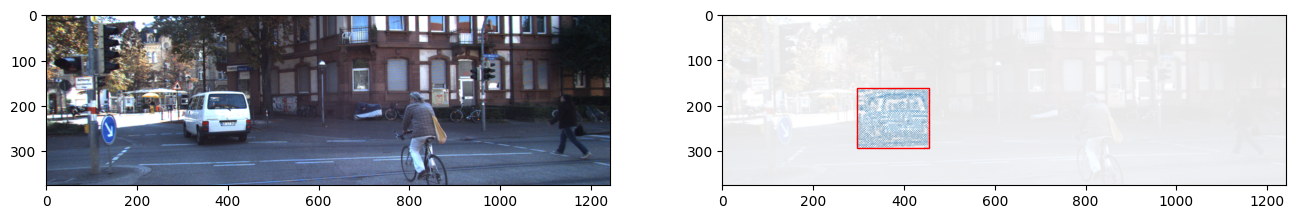

In [21]:
fig, ax = plt.subplots(1,2, figsize=(16, 4))
ax[0].imshow(img)
ax[1].imshow(img, alpha=0.1)



# ax[1].scatter(p2d_float[idx][:,0],p2d_float[idx][:,1], s=0.01, c=depth[idx])
ax[1].scatter(p2d_filtered[:,0], p2d_filtered[:,1], s=0.01)
w = r-l
h = b-t
rect = patches.Rectangle((l, t), w, h, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)
ax[1].set_xlim(0, 1242)
ax[1].set_ylim(0, 375)
ax[1].invert_yaxis()


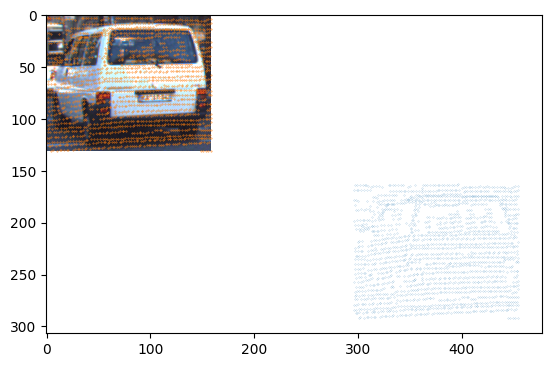

In [22]:
plt.imshow(cropped_img.permute(1,2,0))
plt.scatter(p2d_filtered[:,0], p2d_filtered[:,1], s=0.01)
temp = p2d_filtered - np.array([l,t])
plt.scatter(temp[:,0], temp[:,1], s=0.1)

# input format에 맞춰서 넣어주기

In [23]:
images = torch.cat([input_data['frame_img']], dim=0)[None,:]
overlap_masks = torch.cat([input_data['overlap_mask']], dim=0)[None, :]
sub_clouds = torch.from_numpy(np.stack([input_data['sub_cloud']])).float()
print(overlap_masks.shape)
real_point_mask = torch.from_numpy(np.stack([input_data['real_point_mask']]))


batched_data = EasyDict({
    'images':images,
    'overlap_masks': overlap_masks,
    'sub_clouds': sub_clouds,
    'sub_clouds2d': torch.from_numpy(np.stack([input_data['sub_cloud2d']])).float(),
    'ori_clouds2d': torch.tensor(1),
    'real_point_mask': real_point_mask,
    'foreground_label': torch.tensor(1),
    'locations': torch.from_numpy(np.stack([np.array([0,0,0])])).float(),
    'dimensions': torch.from_numpy(np.stack([np.array([4,1.6,1.5])])).float(),
    'yaws': torch.from_numpy(np.stack([0])).unsqueeze(-1).float()
})

torch.Size([1, 1, 112, 112])


In [41]:
for key in batched_data.keys():
    print(data[key].shape, batched_data[key].shape)

torch.Size([5, 3, 112, 112]) torch.Size([1, 3, 112, 112])
torch.Size([5, 1, 112, 112]) torch.Size([1, 1, 112, 112])
torch.Size([5, 512, 3]) torch.Size([1, 1775, 3])
torch.Size([5, 512, 2]) torch.Size([1, 1775, 2])
torch.Size([5, 512, 2]) torch.Size([])
torch.Size([5, 512]) torch.Size([1, 1775])
torch.Size([5, 512]) torch.Size([])
torch.Size([5, 3]) torch.Size([1, 3])
torch.Size([5, 3]) torch.Size([1, 3])
torch.Size([5, 1]) torch.Size([1, 1])
torch.Size([5, 512, 2]) torch.Size([1, 1775, 2])


In [24]:
out = model(batched_data)

In [26]:
out['location'] + out['subcloud_center'] + out['second_offset']
out['subcloud_center']

tensor([[19.1246,  6.3272, -0.7571]])

In [81]:
# print(out['location'][0], out['dimension'][0])
gamma = torch.cat([out['location'][0], out['dimension'][0], out['yaw'][0]], dim=0)
params = {
    'x': list(),
    'y': list(),
    'z': list(),
    'l': list(),
    'w': list(),
    'h': list(),
    'yaw': list(),
}

for i, p in enumerate(params.keys()):
    params[p].append(gamma[i].item())
    params[p].append(out['box_uncertainty'][0][0][i].item()) # lambda
    params[p].append(out['box_uncertainty'][1][0][i].item()) # alpha
    params[p].append(out['box_uncertainty'][2][0][i].item()) # beta


In [125]:
params['x'][0], params['y'][0], params['z'][0]

(-0.43930602073669434, -0.3959543704986572, -0.20964327454566956)

In [126]:
obj_label['0'][0]

['296.744956',
 '161.752147',
 '455.226042',
 '292.372804',
 '-4.552284',
 '1.858523',
 '13.410495']

['296.744956', '161.752147', '455.226042', '292.372804', '-4.552284', '1.858523', '13.410495']
13.410495 4.552284
['737.619499', '161.531951', '931.112229', '374.000000', '1.640400', '1.675660', '5.776261']
5.776261 -1.6404
['1106.137292', '166.576807', '1204.470628', '323.876144', '6.301919', '1.652419', '8.455685']
8.455685 -6.301919


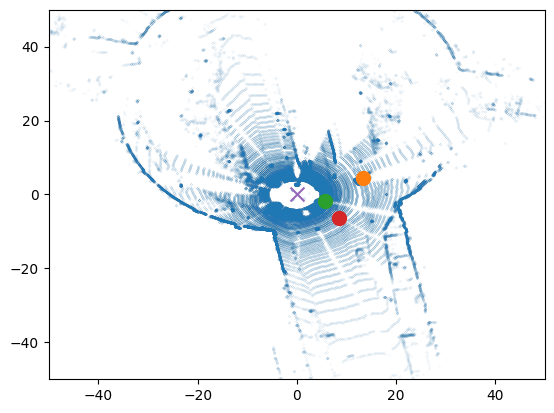

In [112]:
velo_file_format = '/home/user/Downloads/kitti_object_tracking/training/velodyne/0000/000000.bin'

fig, ax = plt.subplots()

with open(velo_file_format, 'rb') as f:
    pcd = np.fromfile(f, dtype=np.float32).reshape(-1, 4)

x, y = pcd[:,0], pcd[:,1]
plt.scatter(x, y, s=0.001)
for obj in obj_label['0']:
    print(obj)
    s1, s2, s3 = [float(x) for x in obj[4:]]
    x, y, z = s3, -s1, s2
    print(x,y)
    plt.scatter(x,y, s=100, marker='o')
plt.scatter(0,0, s=100, marker='x')
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.show()

In [155]:
from IPython.display import clear_output
from time import sleep

(-70.0, 70.0)

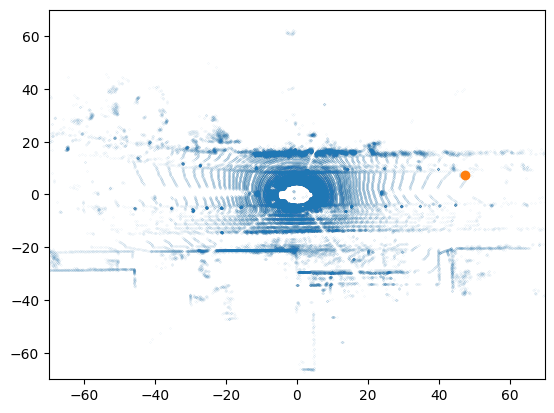

In [304]:


velo_file_format = '/home/user/Downloads/kitti_object_detection/training/velodyne/000007.bin'

fig, ax = plt.subplots()

with open(velo_file_format, 'rb') as f:
    pcd = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
x, y = pcd[:,0], pcd[:,1]
plt.scatter(x, y, s=0.001)
plt.scatter(47.55, 7.43)
plt.xlim(-70, 70)
plt.ylim(-70, 70)

In [89]:
from time import sleep
label_file = '/home/user/Downloads/kitti_object_tracking/training/label_02/{:04d}.txt'.format(0)
 # read bbox
f = open(label_file, 'r')
obj_label = dict()
for obj in f.readlines():
    frame, track_id, cat, trunc, occ, alpha, l, t, r, b, height, width, length, x, y, z, rot = obj.split(' ')
    if frame not in obj_label.keys():
        obj_label[frame] = list()
    if cat == 'DontCare':
        continue
    obj_label[frame].append([l, t, r, b, x, y, z])   
    
for i in range(154):



    sleep(0.01)
    fig, ax = plt.subplots()
    with open('/home/user/Downloads/kitti_object_tracking/training/velodyne/0000/{:06d}.bin'.format(i), 'rb') as f:
        pcd = np.fromfile(f, dtype=np.float32).reshape(-1, 4)
    
    x, y = pcd[:,0], pcd[:,1]
    plt.scatter(x, y, s=0.001)
    
    for obj in obj_label[str(i)]:
        s1, s2, s3 = [float(x) for x in obj[4:]]
        x, y, z = s3, -s1, s2
        print(x,y)
        plt.scatter(x,y)

    plt.xlim(-50, 50)
    plt.ylim(-50, 50)
    
    plt.savefig(f'figure/{i}.png')
    plt.close()

13.410495 4.552284
5.776261 -1.6404
8.455685 -6.301919
13.581085 4.650955
5.778596 -1.70064
8.156156 -6.352093
13.751675 4.749625
5.780931 -1.76088
7.859055 -6.409693
13.922264 4.848295
5.783265 -1.821119
7.560739 -6.463579
14.098646 4.934786
5.7856 -1.881359
7.267796 -6.516488
14.275029 5.021277
5.811552 -1.895126
6.974853 -6.569396
40.289896 10.850808
14.439823 5.118224
5.837503 -1.908893
40.108802 10.342982
14.604162 5.214711
5.863455 -1.92266
39.927707 9.835156
14.768214 5.310908
5.889406 -1.936427
39.746613 9.32733
14.932802 5.407646
5.915358 -1.950193
39.565518 8.819504
15.096252 5.503235
5.9803 -1.950046
39.384424 8.311678
15.238743 5.584318
6.045242 -1.949899
39.140435 7.881526
15.381234 5.665401
6.110184 -1.949752
38.896446 7.451374
15.523726 5.746484
6.175126 -1.949604
38.652458 7.021222
15.666217 5.827567
6.240068 -1.949457
38.408469 6.59107
15.808708 5.90865
6.326126 -1.925884
38.164481 6.160918
15.935761 5.981431
6.412183 -1.902311
37.919635 5.718926
16.060472 6.051844
6.4

In [222]:
np.sin(np.pi/2)

1.0

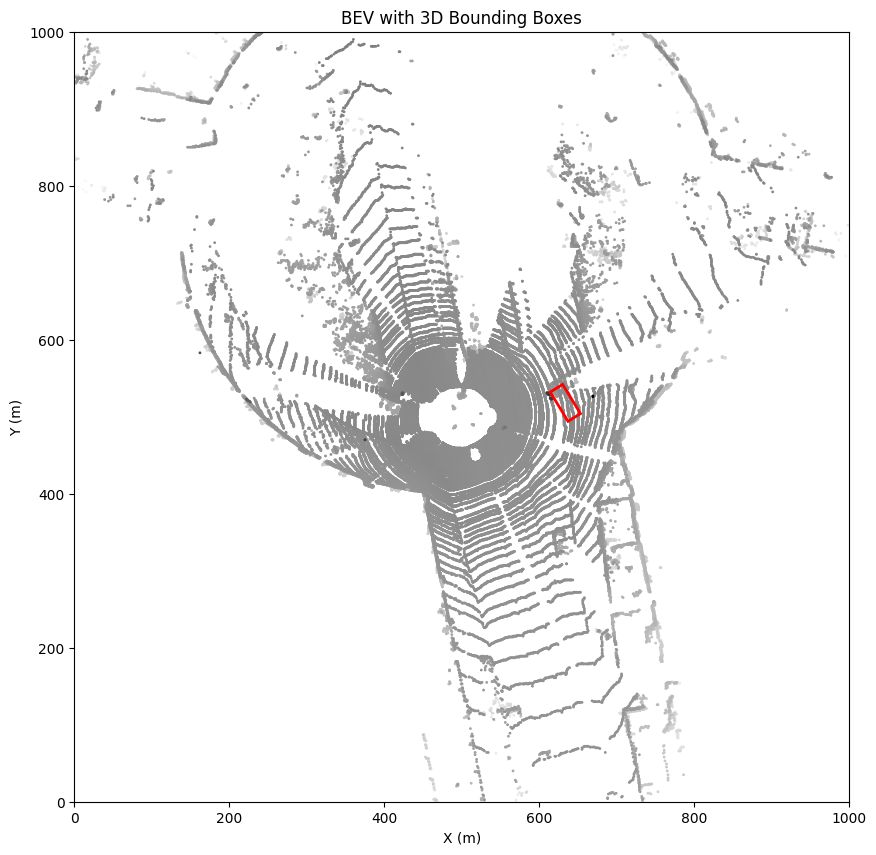

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Point cloud 파일 읽기
def load_point_cloud(bin_path):
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

# Bounding box 정보 읽기
def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            data = line.strip().split()
            if data[2] != 'DontCare':  # Car 객체만 고려
                bbox = {
                    'type': data[0],
                    'x': float(data[11]),
                    'y': float(data[12]),
                    'z': float(data[13]),
                    'h': float(data[8]),
                    'w': float(data[9]),
                    'l': float(data[10]),
                    'yaw': float(data[14])
                }
                labels.append(bbox)
    return labels

# Point cloud를 BEV로 변환
def point_cloud_to_bev(point_cloud, x_range, y_range, resolution):
    mask = (point_cloud[:, 0] > x_range[0]) & (point_cloud[:, 0] < x_range[1]) & \
           (point_cloud[:, 1] > y_range[0]) & (point_cloud[:, 1] < y_range[1])
    bev_points = point_cloud[mask]
    bev_x = ((bev_points[:, 0] - x_range[0]) / resolution).astype(np.int32)
    bev_y = ((bev_points[:, 1] - y_range[0]) / resolution).astype(np.int32)
    return bev_x, bev_y, bev_points

# Bounding box를 BEV로 변환 및 그리기
def draw_bounding_box(ax, bbox, x_range, y_range, resolution):
    corners = np.array([
        [bbox['x'] - bbox['l']/2, bbox['y'] - bbox['w']/2],
        [bbox['x'] - bbox['l']/2, bbox['y'] + bbox['w']/2],
        [bbox['x'] + bbox['l']/2, bbox['y'] + bbox['w']/2],
        [bbox['x'] + bbox['l']/2, bbox['y'] - bbox['w']/2],
    ])
    # yaw 회전 적용
    rotation_matrix = np.array([
        [np.cos(bbox['yaw']), -np.sin(bbox['yaw'])],
        [np.sin(bbox['yaw']), np.cos(bbox['yaw'])]
    ])
    corners = np.dot(corners - [bbox['x'], bbox['y']], rotation_matrix.T) + [bbox['x'], bbox['y']]
    # BEV 좌표 변환
    bev_corners = (corners - [x_range[0], y_range[0]]) / resolution
    bev_corners = bev_corners.astype(np.int32)
    polygon = plt.Polygon(bev_corners, edgecolor='red', fill=False, linewidth=2)
    ax.add_patch(polygon)

# 메인 함수
def main():
    # 파일 경로
    # bin_path = "path_to_velodyne_bin_file.bin"
    # label_path = "path_to_label_file.txt"
    bin_path = '/home/user/Downloads/data_tracking_velodyne/training/velodyne/0000/000000.bin'
    label_path = '/home/user/Downloads/training/label_02/0000.txt'

    # Point cloud 및 라벨 로드
    point_cloud = load_point_cloud(bin_path)
    labels = load_labels(label_path)
    
    # BEV 파라미터
    x_range = (-50, 50)
    y_range = (-50, 50)
    resolution = 0.1  # 1 픽셀당 0.1m
    
    # Point cloud를 BEV로 변환
    bev_x, bev_y, bev_points = point_cloud_to_bev(point_cloud, x_range, y_range, resolution)
    
    # BEV 시각화
    plt.figure(figsize=(10, 10))
    plt.scatter(bev_x, bev_y, s=1, c=bev_points[:,2], cmap='gray')
    
    # Bounding box 그리기
    ax = plt.gca()
    labels = [
        {
            'type': 'a',
            'x': float(13.4),
            'y': float(1.85),
            'z': float(-4.55),
            'h': float(2),
            'w': float(1.823),
            'l': float(4.4338),
            'yaw': float(2.11)
        }
    ]
    for bbox in labels:
        draw_bounding_box(ax, bbox, x_range, y_range, resolution)
    
    plt.xlim(0, int((x_range[1] - x_range[0]) / resolution))
    plt.ylim(0, int((y_range[1] - y_range[0]) / resolution))
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("BEV with 3D Bounding Boxes")
    plt.show()

if __name__ == "__main__":
    main()
